**NB ROOT su notebook fa pena crasha di continuo, non usarlo MAI. Qui usato solo per averer spiegazioni, codici e risultati insieme**

# ROOT
Root è un framework dotato di routine di analisi dati, statistica, grafici e metodi avanzati di input/output

Root ha un interprete built-in (cling) che in realtà è un just in time compiler ed è dotato di un wrapper python

## I/O
Le informazioni vengono salvatge e lette in  formato colonnare. Ovvero ogni riga corrisponde a un evento. Un evento può avere un numero arbitrario di particelle a cui sono associati diversi dati (energia, etc.)
In una semplice lista python avremmo un tensore in cui ogni riga possiede un numero di colonne variabile e sarebbe molto difficile da gestire

L'interprete di ROOT supporta dei comandi speciali che hanno come prefisso un punto
- .q: chiudi root
- .! usa comandi di sistema
- .L file_name carica una macro (Per creare una macro basta scrivere un file cpp chiamato Macroname con dentro una funzione MacroName) per poi chiamarla quando si vuole. La macro viene eseguita JIT
- .L file_name+ In questo modo la macro viene compilata e viene generata una shared library
- .help help sui comandi speciali

Per compilare un programma cpp che include pacchetti di root bisogna usare la seguente flag
`root-config --cflags --libs`

## Files
In ROOT i file vengono gestiti dalla classe TFile. I TFile sono bei binari aventi un  header e un record e possono essere compressi.

I TFile hanno una struttura logica simile a quella di un filesystem ovvero hanno una gerarchia di directory.
Inoltre sono auto descrittivi cioè l'informazione che serve per leggere il file è nel file stesso (possiamo leggerlo in qualsiasi modo senza dover usare per forza le classi root)

Per scrivere i file ci sono 3 passaggi:
1. Serializzazione: Bisogna convertire i dati in un blob di byte evitando loop e seguendo i puntatori correttamente. Inoltre è necessario che la serializzazione sia indipendente dall' enviroment.
   Dato l'header file della classe viene creato un dizionario
2. Compressione
3. Scrittura

Per creare un file bisogna istanziare un oggetto TFile("path","OPZIONE"). Se non passiamo alcuna opzione significa che stiamo aggendo in sola lettura. Tipicamente si usa **"RECREATE"** per scrivere e sovrascrivere un file o **UPDATE** per aggiungere roba al file

Per scrivere un oggetto nel file basta usare oggetto.Write() Poi bisogna chiudere il file

**Anche qui c'è l'idea stupida del current open file.**:
Per cambiare il current file bisogna usare il comando old_file.cd()


Altri comandi sono:
- .GetObject("nome_oggetto",nome_variabile) Per leggere un oggetto e scriverlo in variabile (bisogna prima creare la variabile e deve essere un puntatore)
- .GetListOfKeys() ritorna un iterabile contenente tutti gli oggetti scritti nel file e con .GetName() sul singolo elemento si può ottenere il nome



In [1]:
TFile f("file.root","RECREATE");
TH1F h("histo","histo",100,0,100);
h.Write();
f.Close();

### Formato colonnare
I dati sono divisi in blocchi di righe contenenti gli eventi (**entries**) e in colonne contenenti dati diversi (es. impulso, angoli...) (**branches**)

Questi dati però non èpossono essere rappresentati in vettori perchè hammp una struttura gerarchica ad albero
![title](img/file.png)

Questa rappresentazione è efficiente sia a Runtime (non bisogna leggere per forza tutto se ci interessa solo una parte dei dati), sia per quanto riguarda lo storage (poichè ogni colonna contiene dati simili tra loro e la loro compressione diventa più efficiente)

### TTree
Il formato colonnare in un file root è rappresentato dai TTree.
Le colonne del tree sono i branch e le righe sono una entry

#### TNtuple
TNtuple tuple("nome","titolo","x,y");

Una versione semplificata è la **TNtuple** ovvero un tree che ha come branch delle singole variabili numeriche.
Possiamo fare plot sulle NTuple usando il metodo .Draw("formula","mask")
(ad esempio se vogliamo il prodotto dell'impulso x e y considerando solo le entries con pz>0 è tuple.Draw("px*py","pz>0"))

In realtà quella non è una mask ma un peso, in questo caso abbiamo usato una espressione booleana quindi è una mask ma possiamo anche decidere di pesare i nostri px*py con pz stesso

#### tree
Per creare delle Bracnhce dopo aver costruito il tree bisogna fare
tree.Branch("nome_branch",&variabile) dove &variabile è l'indirizzo di memoria che contiene il dato da aggiungere nel branche

Dopo che in x mettiamo il dato che ci interessa facciamo tree.Fill() e in questo modo aggiungiamo una entries

Per leggerlo invece si usa l'oggetto TTreeReader("tree_name_to_read", &Tfile_name)

In [ ]:
//Leggere un tree///////
////////////////////////
Tile f("file.root");

//creo un reader
TTreeReader reader("tree_name",&f);



//creo iterabile su un branch
TTreeReaderValue<Object_type> BR(reader,"branch_name");

while(reader.Next()){
    for (auto &obj : *BR){
        //operazioni sull'oggetto
    }
}


## Istogrammi
La classe che gestisce gli istogrammi è TH1. Da questa eredita TH1F (F sta per float) che è la più usata ma anche TH2 e TH3 che è una cosa abbastanza stupida poichè un istogramma 2d o 3d non è un caso particolare di istogramma a una dimensione

Per disegnare un istogramma bisogna creare un'istanza TH1F che ha come parametri("nome_hist","titolo",num_bin,xinf,xsup)

Per mostrarlo bisogna creare un TCanvas ("nome", "titolo",height, width) e poi fare hist.Draw() e  canv.Draw()
(canvas )
**NB In root c'è una variabile interna che si chiama current TCanvas che, a meno che non venga cambiata a mano, corrisponde all'ultima TCanvas creata. Lo stesso vale quando si fa il fill dell'istogramma. (E' una porcheria, non è neanche thread safe)

La canvas corrente è nella variabile builtin gpad. **E' un puntatore globale (gPad->SetGrid() equivale a lastcanvascreated.SetGrid())

**NB In una macro è necessario creare TH1F con new allocandolo nell'heap altrimenti come si esce dallo scope della funzione l'istogramma viene distrutto. Ricorda che poi va distrutto. In modalità interattiva si può evitare**

Volendo possiamo riempire l'istogramma con numeri casuali con FillRandom.

### Opzioni sugli istrogrammi
Gli istogrammi possono essere personalizzati sia con altri comani come.SetFillColor(colore), sia passando delle stringhe a .Draw() (Es. "E" per gli errori.Di default root mette errori poissoniani sui bin)
Per disegnare altra roba sopra un istrogramma già esistente bisogna usare l'opzione SAME.  Per usare più opzioni basta attaccare le stringhe insieme senza separatori
Per salvarli si usa il comando .SaveAs(name.png) sulla canvas

Le tabelle riassuntive presenti di default negli istogrammi possono essere modificate usando variabili interne globali come gStyle->SetOptStat() e a questa funzione va passata una sequenza di 0 e 1 per decidere quali info mostrare e quale no

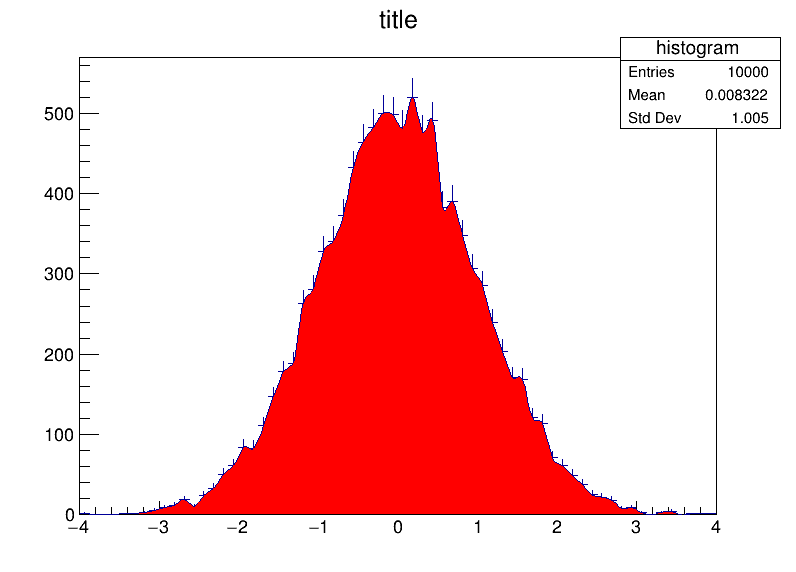

In [1]:
TH1F *hist =new TH1F("histogram","title",64,-4,4);
TCanvas c("myCanvasName","The Canvas Title",800,600);
hist->FillRandom("gaus",10000);

//hist->Draw("E"); //Il comando E disegna istogramma con errori
hist->Draw("E");
hist->SetFillColor(kRed); //riempie istogramma
hist->Draw("SAMEC"); //Ridisegna la stessa cosa ma con una linea continua riempita di rosso
c.Draw();


# Funzioni
Le funzioni sono rappresentate dalla classe TF1 (da R a R, ci sono anche TF12, TF2, TF3).
Root è dotato di algoritmi numerici per calcolare derivate e integrali delle TF1

Le TF1 possono essere istanziate in 2 modi:
- Come stringhe (inoltre esistono delle funzioni builtin tipo "gaus" per la gaussiana media 0 varianza 1)
- Come funzioni C++ o lambdas

I parametri si esprimono con parentesi quadre



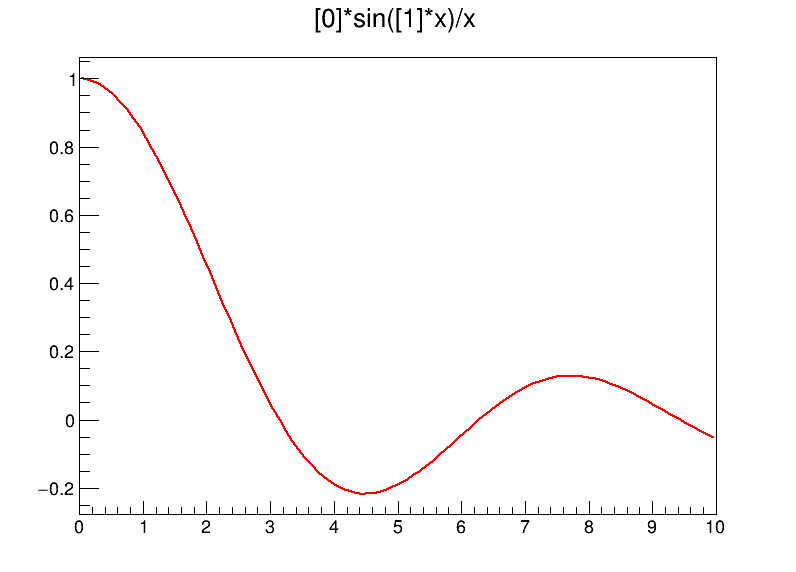

In [1]:
//Plot di funzione (qui non uso f1= new TF1 ma in uno script va fatto per forza in questo modo)
TCanvas c("myCanvasName","The Canvas Title",800,600);

//0 e 1 sono parametri
TF1 f1("nome","[0]*sin([1]*x)/x",0.,10.);
f1.SetParameters(1.,1.);
f1.Draw();
c.Draw();

# TGraph
E' una sorta di scatterplot(molto simile al .plot di matlotlib)

Per aggiungere un punto al TGraph bisogna usare .SetPoint(num_punto,x,y) *Per gli istogrammi si usa Fill*

Opzioni:
- .SetMarkerStyle e .SetMarkerSize Per campbiare marker
- .SetMarkerColor e SetLineColor per cambiare colore del marker o della linea
- .SetLineStyle .SetLineWidth per cambiare stile e grandezza della linea
- .SetTitle("titolo;asse x; assey") Per cambiare titolo e label assi
- ci sono altri comandi tipo per la trasparenza 

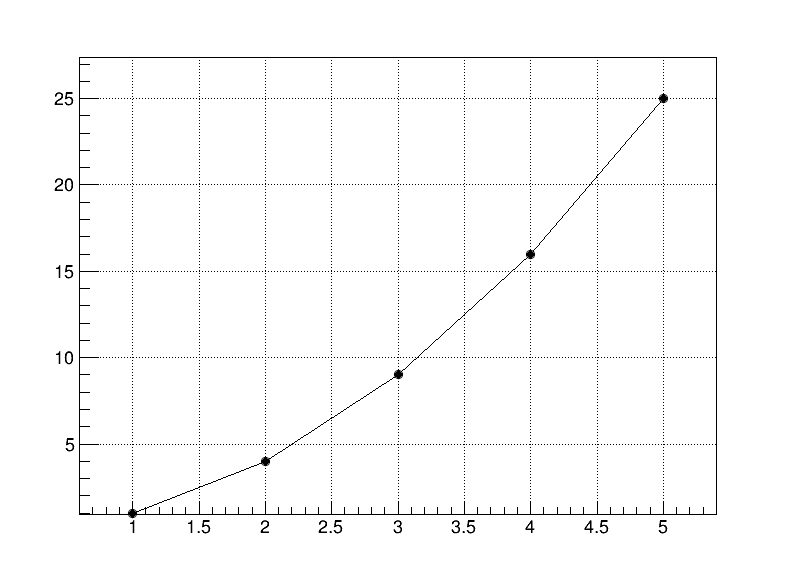

In [1]:

#include <tuple>
#include <vector>
using namespace std;
TGraph g;
TCanvas  c ("myCanvasName","The Canvas Title",800,600);
vector<double> points {1,2,3,4,5};
for (auto [idx,x]=tuple{0,points.begin()}; x != points.end(); ++idx, ++x) {
    g.SetPoint(idx,*x,(*x)*(*x));
}
g.SetMarkerStyle(kFullCircle);
g.Draw("APL");
c.SetGrid();
c.Draw();

**Opzioni sulla canvas**:
- .SetGrid() mette griglia
- TLatex text(x,t,"testo"); test.Draw();  scrive del testo in latex sul grafico
- .SetLogx() .SetLogy() per la scala logaritmica

**Stili grafici**

Lo stile corrente è contenuto nel puntatore globale **gStyle**. 
Gli stili sono gestiti dalla classe TStyle e un utente può definire il proprio stile (di solito ogni esperimento crea il proprio. I built-in sono Plain, Bold, Pub, Modern (di default))

# Plot 2D

## Colormap
Possiamo fare delle colormap tramite la classe TH2F e quando facciamo draw usiamo l'opzione "colz" (ovvero colora la coordinata z)
La colormap di default è kBird (EVITA LA RAINBOW ASSOLUTAMENTE)
 